In [32]:
import numpy as np
import xarray as xr
import netCDF4
import os
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
import glob

In [74]:
data_dir = r"/home/raraki/waves/projects/smap-drydown/data"
datarod_dir = r"/home/raraki/waves/projects/smap-drydown/data/datarods"
rangeland_dir = "rangeland_resampled_avg"
shape = (406, 964)
width = shape[1]

# Get template EASE grid

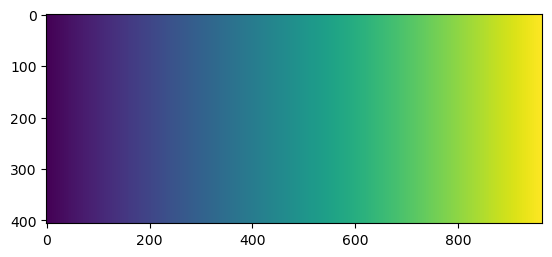

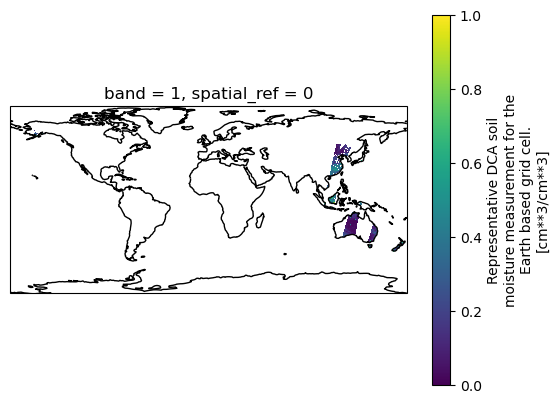

In [75]:
SMAPL3_grid_sample = r"/home/waves/projects/smap-drydown/data/SPL3SMP/SMAP_L3_SM_P_20150331_R18290_001.h5"
ncf = netCDF4.Dataset(SMAPL3_grid_sample, diskless=True, persist=False)
nch_am = ncf.groups.get('Soil_Moisture_Retrieval_Data_AM')
nch_pm = ncf.groups.get('Soil_Moisture_Retrieval_Data_PM')

# %%
# Return as regular numpy array rather than masked array
_latitude = ma.getdata(nch_am.variables['latitude'][:].filled(fill_value=np.nan), subok=True)
_longitude = ma.getdata(nch_am.variables['longitude'][:].filled(fill_value=np.nan), subok=True)
_EASE_column_index = ma.getdata(nch_am.variables['EASE_column_index'][:].astype(int).filled(fill_value=-1), subok=True)
_EASE_row_index = ma.getdata(nch_am.variables['EASE_row_index'][:].astype(int).filled(fill_value=-1), subok=True)

# %%
# Coordinates with no data are skipped --- fill them
latitude = np.nanmax(_latitude, axis=1)
EASE_row_index = np.nanmax(_EASE_row_index, axis=1)
longitude = np.nanmax(_longitude, axis=0)
EASE_column_index = np.nanmax(_EASE_column_index, axis=0)

EASE_row_index_expanded = np.tile(EASE_row_index, (len(EASE_column_index), 1)).T 
EASE_column_index_expanded = np.tile(EASE_column_index, (len(EASE_row_index), 1))
plt.imshow(EASE_column_index_expanded)

_ds_SMAPL3 = xr.open_dataset(SMAPL3_grid_sample, engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable=['soil_moisture'])
ds_SMAPL3_coord_template = _ds_SMAPL3.assign_coords({'x':longitude, 'y':latitude}).rio.write_crs("epsg:4326")

import cartopy.crs as ccrs
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': projection})
# Plot the new data
ds_SMAPL3_coord_template.sel(band=1).Soil_Moisture_Retrieval_Data_AM_soil_moisture.plot(ax=ax, transform=projection, vmin=0, vmax=1)
ax.coastlines()
plt.show()

# Import resampled data

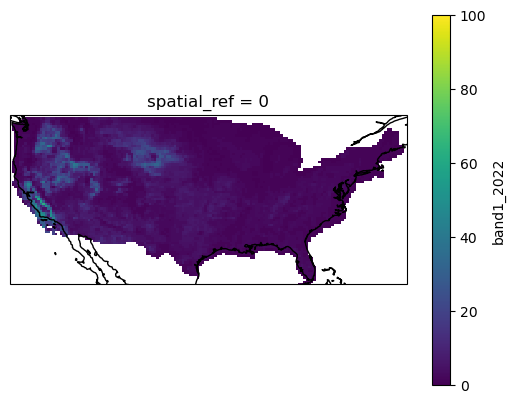

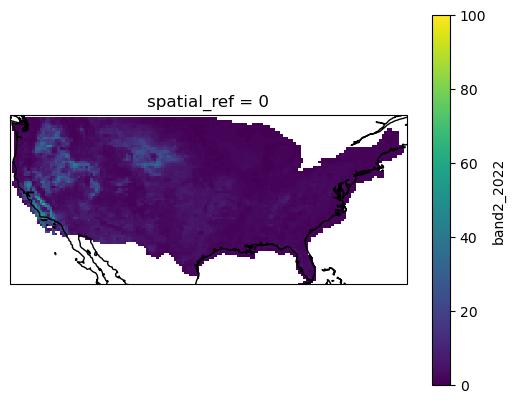

In [76]:
# Define the range of years and band numbers
years = [2022] #range(2015, 2023)  # 2023 is not included, so it goes up to 2022
band_numbers = range(1, 3)  # 7 is not included, so it goes up to 6

for year in years:
    for band in band_numbers:
        base_dir = os.path.join(data_dir, rangeland_dir)
        file=f"{year}_band{band}.nc"
        _ds = xr.open_dataset(f"{base_dir}/{file}")
        _ds = _ds.rename({'__xarray_dataarray_variable__': 'landcover_fraction'})
        _ds['landcover_fraction'] = _ds['landcover_fraction'].where(_ds['landcover_fraction'] <= 100, np.nan)
        
        var_name = f"band{band}_{year}"
        ds_SMAPL3_coord_template[var_name] = _ds['landcover_fraction']
        
        fig, ax = plt.subplots(subplot_kw={'projection': projection})
        conus_extent = [-125, -66.5, 24.5, 49.5]
        ds_SMAPL3_coord_template[var_name].plot(ax=ax, transform=projection, vmin=0, vmax=100)
        ax.set_extent(conus_extent, crs=ccrs.PlateCarree())
        ax.coastlines()
        plt.show()


In [78]:
EASE_column_index_xarray = xr.DataArray(EASE_column_index_expanded, dims=('y', 'x'), coords={'y': ds_SMAPL3_coord_template['y'], 'x': ds_SMAPL3_coord_template['x']})
ds_SMAPL3_coord_template['EASE_column_index'] = EASE_column_index_xarray

EASE_row_index_xarray = xr.DataArray(EASE_row_index_expanded, dims=('y', 'x'), coords={'y': ds_SMAPL3_coord_template['y'], 'x': ds_SMAPL3_coord_template['x']})
ds_SMAPL3_coord_template['EASE_row_index'] = EASE_row_index_xarray

In [80]:
list_varnames = []
for year in years:
    for band in band_numbers:
        list_varnames.append(f"band{band}_{year}")
new_variable_names = ['EASE_column_index', 'EASE_row_index'] + list_varnames
df = ds_SMAPL3_coord_template[new_variable_names].to_dataframe()
df.index.names = ['latitude', 'longitude']
df

EASE_column_index  EASE_row_index  band1_2022  \
latitude   longitude                                                    
 83.631973 -179.813278                  0               0         NaN   
           -179.439835                  1               0         NaN   
           -179.066391                  2               0         NaN   
           -178.692947                  3               0         NaN   
           -178.319504                  4               0         NaN   
...                                   ...             ...         ...   
-83.631973  178.319504                959             405         NaN   
            178.692947                960             405         NaN   
            179.066391                961             405         NaN   
            179.439835                962             405         NaN   
            179.813278                963             405         NaN   

                        band2_2022  spatial_ref  
latitude   longitude                             
 83.631973 -179.813278         NaN            0  
           -179.439835         NaN            0  
           -179.066391         NaN            0  
           -178.692947         NaN            0  
           -178.319504         NaN            0  
...                            ...          ...  
-83.631973  178.319504         NaN            0  
            178.692947         NaN            0  
            179.066391         NaN            0  
            179.439835         NaN            0  
            179.813278         NaN            0  

[391384 rows x 5 columns]

# Output

In [81]:
filename = r"/home/raraki/waves/projects/smap-drydown/data/datarods/anc_info_rangeland.csv"
df.to_csv(filename)

In [82]:
import pandas as pd
data = pd.read_csv(filename)
data.head()

,latitude,longitude,EASE_column_index,EASE_row_index,band1_2022,band2_2022,spatial_ref
0,83.63197,-179.81328,0,0,NaN,NaN,0
1,83.63197,-179.43983,1,0,NaN,NaN,0
2,83.63197,-179.06639,2,0,NaN,NaN,0
3,83.63197,-178.69295,3,0,NaN,NaN,0
4,83.63197,-178.31950,4,0,NaN,NaN,0
